# Multiparametric MRI - SNR, CNR

A.L. MMIV-ML 20211025

(Modified from BMED360-2021 ver. 2021-03-20 A.Lundervold:<br>
https://github.com/computational-medicine/BMED360-2021/blob/main/Lab1-MRI/03-mri-snr-cnr.ipynb)

## Learning objectives:

**I this stepwise development of code (notebooks `02-mri-` and `03-mri-`) you will**: 

- Learn to measure "[contrast-to-noise](https://en.wikipedia.org/wiki/Contrast-to-noise_ratio) ratios" (CNR) in multispectral (brain) [MRI](https://en.wikipedia.org/wiki/Magnetic_resonance_imaging) between each pair of seven different tissue types (*air/bone* [air], *gray matter* [gm], *white matter* [wm], *cerebrospinal fluid* [csf], *fat* [fat] and *muscle* [mus]) in each of four channel images (flash, dess, fisp, and psif) from a sagittal slice of the head (see figure below (# Four channel ...)).


- You will learn that in a larger context **multispectral** MRI and **multiparametric** MRI denote the same concept: **every pixel (or voxel) have vectorial values** where each component in the [vector](https://en.wikipedia.org/wiki/Vector_(mathematics_and_physics)) represents signal intensity (at that location) in a specific MRI pulse sequence (typical for [multispectral](https://en.wikipedia.org/wiki/Multispectral_image) MRI), or an image-derived parameter value e.g. physiologcal, biochemical, or [textural](https://en.wikipedia.org/wiki/Image_texture) features (typical for multiparametric MRI, or in [radiomics](https://en.wikipedia.org/wiki/Radiomics)).

 
- You will also get **insight into representation** and **manipulation of digital images** (see notebook [`01-mri-intro`](./01-mri-intro.ipynb)): image formats (DICOM, NIFTI, PNG); [binary](https://en.wikipedia.org/wiki/Binary_image) (0/1) images, [grayscale](https://en.wikipedia.org/wiki/Grayscale) images and RGB [color](https://en.wikipedia.org/wiki/Color_image) images; different **[data types](https://en.wikipedia.org/wiki/Data_type)** (float, uint8, RGB) of images; and anatomical orientation (geometry) of recorded images - which is important in medical images   (e.g. up-down, left-right, anterior-posterior) cf. the [standard anatomical position](https://en.wikipedia.org/wiki/Standard_anatomical_position). 

# Theory: 

We define the **signal** S$_A$ for a given tissue $A$ to be the mean signal inetensity within a region of pixels (denoted a mask) covering the tissue type $A$ (and covering this tissue only, otherwise, we will have a "contaminated" mask). 

We define the **contrast** between a pair of tissues $A$ and $B$ to be the signal difference C$_{AB}$ = S$_A$ - S$_B$, where we assume S$_A$ > S$_B$ such the contrast is always non-negative (alternatively: C$_{AB}$ = |S$_A$ - S$_B$|). 

For a tissue $A$, we define the **signal-to-noise-ratio**, denoted SNR$_A$, to be the ratio between the signal ($A$) and the noise, i.e. SNR$_A$ =
S$_A$ / $\sigma_0$, where $\sigma_0$ is the noise level. 

For simplicity we assume the **noise** $\sigma_0$ to be the same for all tisues and equal to the standard deviation of the background signal intensity (i.e. $\sigma_0$ = $\sigma_{air}$). 

This leads to the following definition of **contrast-to-noise-ratio**, CNR between tissue $A$ and tissue $B$

> CNR$_{AB}$ = C$_{AB}$ / $\sigma_0$ = (|S$_A$ - S$_B$|) / $\sigma_0$ = |SNR$_A$ – SNR$_B$|


See also [CNR i wikipedia](https://en.wikipedia.org/wiki/Contrast-to-noise_ratio), and [On the Definition of Signal-To-Noise Ratio and Contrast-To-Noise Ratio for fMRI Data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3819355)

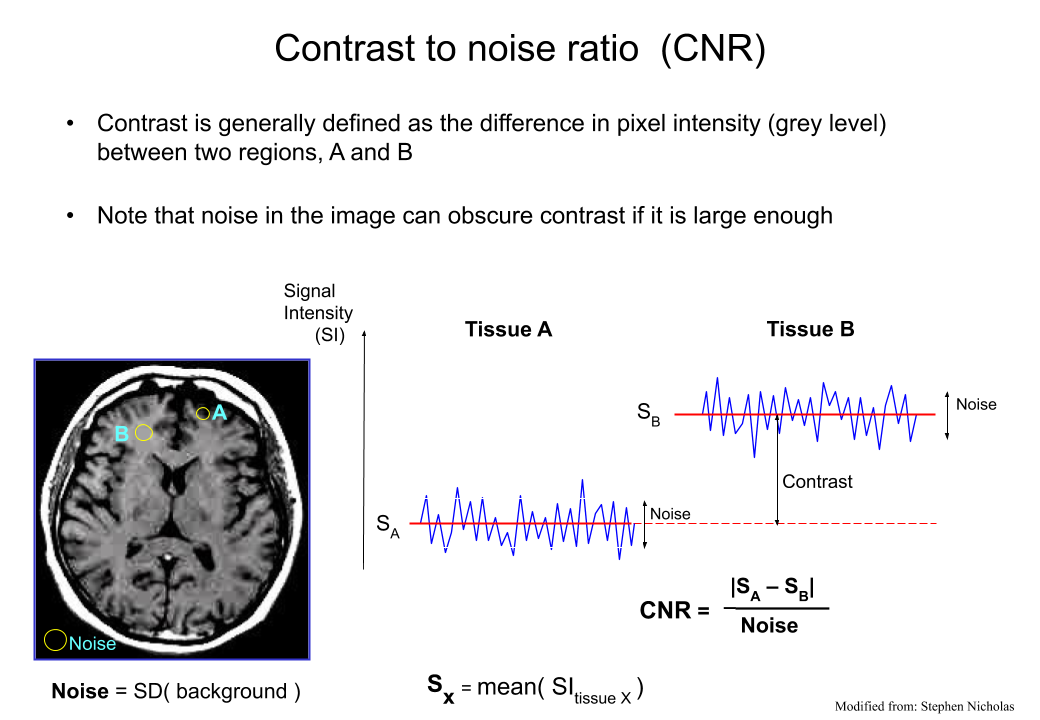

In [1]:
from IPython.display import Image
Image(filename='./assets/BMED_360_Lec1_introduction_mri_ip_CNR.png', width=800)

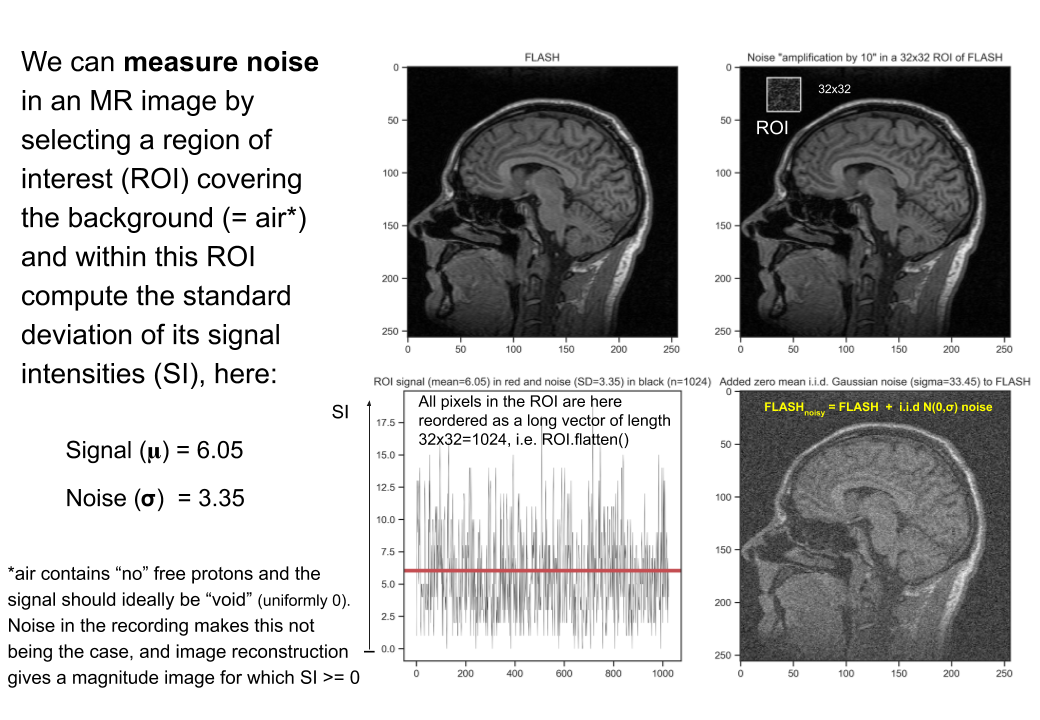

In [2]:
from IPython.display import Image
Image(filename='./assets/BMED_360_Lec1_introduction_mri_ip_measuring_noise.png', width=800)

## Four-channel multispectral MR image and corresponding training masks 

We will be working with a four-channel multispectral image (slice 60 from a multispectral 3D acquisition),  <br>
reported in Lundervold et al. Volume distribution of cerebrospinal fluid using multispectral MR
imaging. <br> _Medical Image Analysis_ 2000;4:123-136. https://www.ncbi.nlm.nih.gov/pubmed/10972326, <br>
and a manually delineated training mask consisiting of six tissue types (color-coded in [R,G,B]) as follows: 

 - AIR (air/bone) in Magenta [255,0,255]
 - GM  (grey matter) in Red  [255,0,0] 
 - WM  (white matter) in Cyan [0,255,255]
 - CSF (cerebrospinal fluid) in Blue [0,0,255]
 - MUS (muscle) in Green [0,255,0] 
 - FAT (fat) in Yellow [255,255,0]
 
**CHECK OUT:** *Multispectral MR image analysis started with the seminal work of [Vannier et al.](https://www.ncbi.nlm.nih.gov/pubmed/3964938), Radiology 1985 <br> - inspired by research on remote sensing at NASA!*

**Figure illustrating multispectral MRI data and manually delineated color-coded pixels beloning to six different tissue types ("classes")**

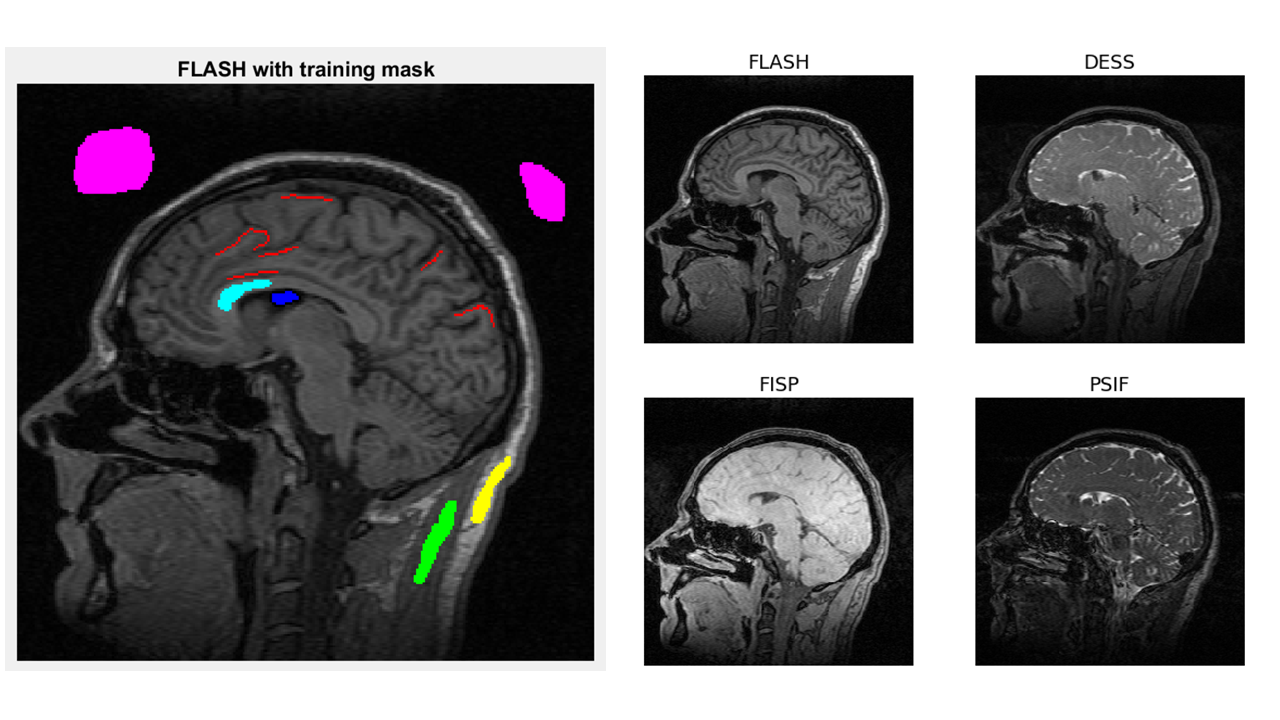

In [3]:
from IPython.display import Image
Image(filename='./assets/multispectral_tissue_classification_pptx.png', width=800)

 > **$\rightarrow$ Your turn!** 
 >
 > - Which channel (pulse sequence) do you find having the overall best CNR? (zoom in)

# Image space and feature space

Using digital image analysis and machine learning we will need to represent information in various **abstract spaces**, some of which are continuous (**vector spaces**), some are discrete "grids" (**multidimensional matrices**):

- **Scanner space** (3D) is characterized by its scanner (world) coordinates $(x,y,z) \in R^3$  
- **Image space** (2D or 3D), where our pixels or voxels live, is characterized by position/location or image coordinates. 
  - For 2D images we have rows ($i$) and columns ($j$), i.e.  $(i,j) \in N \times N$.
  - For 3D images we have rows ($i$), columns ($j$) and slices ($k$), i.e. $(i,j,k) \in N \times N \times N$.
  - For dynamic 3D+time images we have rows ($i$), columns ($j$), slices ($k$) and time points ($t$), i.e. $(i,j,k,t) \in N \times N \times N \times R$
- **Data space** (feature vector space, $R^p$) denoting the space where the signals from our measurements live (assuming $p$ measurements per unit, e.g. voxel), or space where some image-derived features live (e.g. texture, edge strength, filter responses, ...)

The figure below illustrates **image space** and **feature space** in the context of multispectral MRI, here multispectral ($p=3$) 2D images. <br> (in reality we have data from $p=4$ channels, restricting to signal intensisties (SI) from the firts three channels in the lower left of the figure)

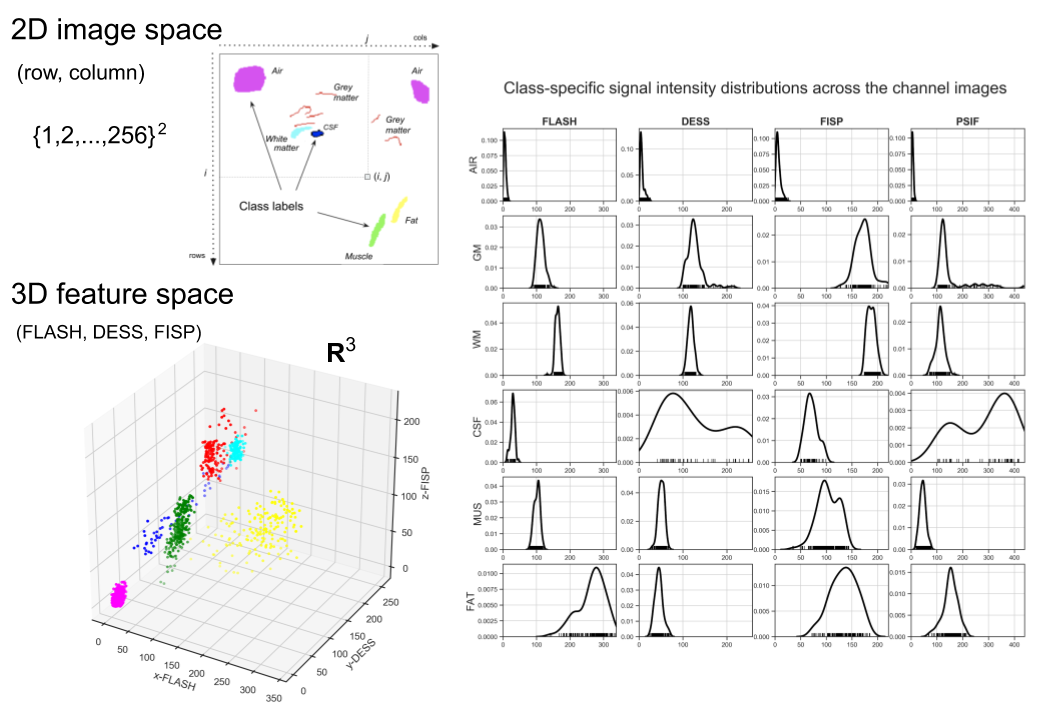

In [4]:
from IPython.display import Image
Image(filename='./assets/BMED_360_Lec1_introduction_mri_ip_image_space_feature_space.png', width=800)

# Setup our Python environment

In [5]:
%matplotlib inline
# This to be able to display figures and graphs within the notebook browser

import os
import pathlib
import glob
import shutil
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
import scipy
import cv2
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
import skimage
import IPython

home = os.path.expanduser('~')  # home is to make path to local home directory

print('pandas:',pd.__version__)
print('nibabel:',nib.__version__)

/Users/arvid/opt/anaconda3/envs/tumor-cnr/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


pandas: 1.3.4
nibabel: 3.2.1


##  MRI pulse sequences  (measurement techniques)

[MRI pulse sequence abbrev.](https://radiopaedia.org/articles/mri-pulse-sequence-abbreviations):

 - FLASH - Fast Low Angle Shot [[ref](https://en.wikipedia.org/wiki/Fast_low_angle_shot_magnetic_resonance_imaging)]
 - DESS - Double Echo Steady State [[ref](http://mriquestions.com/dess.html)]
 - FISP - Fast Imaging with Steady-state free Precession [[ref](http://mriquestions.com/psif-vs-fisp.html)]
 - PSIF - reverse FISP

**Define directories, channel names and class labels [tissue types](https://en.wikipedia.org/wiki/Tissue_(biology)) being used**

In [6]:
mydata = '../data'
chn_names = ['FLASH', 'DESS', 'FISP', 'PSIF']
class_names = ['air', 'gm', 'wm', 'csf', 'mus', 'fat']

#  Read (previously stored) multispectral image

In [7]:
fn_multispectral = '../data/multispectral_mri.nii.gz'
img = nib.load(fn_multispectral)

## Show characteristics of the multispectral NIFTI image

In [8]:
print('shape of image = ', img.header.get_data_shape())
print('units = ', img.header.get_xyzt_units())
print('voxel size = ', img.header.get_zooms())
print('dtype = %s' % img.header.get_data_dtype())
data = img.get_fdata()
print('min = %.1f' % data.min())
print('max = %.1f' % data.max())
print('number of channels =', img.shape[-1])
# Collaps the singular (z-)dimension
dat = np.uint16(data.squeeze())
print('shape of 2D+spectral dat = ',dat.shape)
print('dtype of 2D+spectral dat = ',dat.dtype)

shape of image =  (256, 256, 1, 4)
units =  ('unknown', 'unknown')
voxel size =  (1.0, 1.0, 1.4, 1.0)
dtype = float64
min = 0.0
max = 493.0
number of channels = 4
shape of 2D+spectral dat =  (256, 256, 4)
dtype of 2D+spectral dat =  uint16


## Display image data of the various channels in the multispectral image

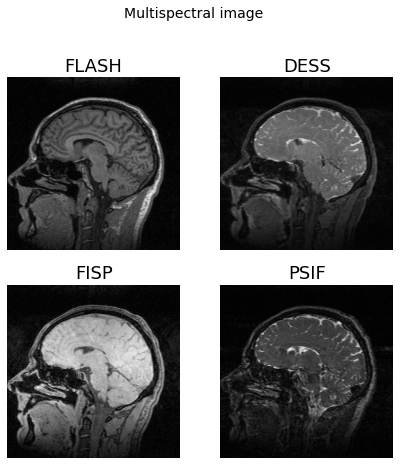

In [9]:
fig = plt.figure('Showing the multispectral image', figsize = [7, 7])
plt.tight_layout
plt.subplot(2, 2, 1).set_axis_off(), plt.title(chn_names[0], fontsize=18)
plt.imshow(dat[:, :, 0].T, cmap='gray', origin='lower')  # .T for transpose to correct orientation
plt.subplot(2, 2, 2).set_axis_off(), plt.title(chn_names[1], fontsize=18)
plt.imshow(dat[:, :, 1].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 3).set_axis_off(), plt.title(chn_names[2], fontsize=18)
plt.imshow(dat[:, :, 2].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 4).set_axis_off(), plt.title(chn_names[3], fontsize=18)
plt.imshow(dat[:, :, 3].T, cmap='gray', origin='lower')
plt.suptitle("Multispectral image", fontsize=14, y=1.02)
plt.show()

# Noise in the (MR) image: analyze noise, add noise

In this section we will explore and manipulate the FLASH data with respect to image noise.
We will construct a noisy FLASH image using i.i.d additive  $N(\mu, \sigma)$ (Gaussian) noise to the original FLASH recording. (i.i.d. = [independent and identically disributed](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables); $\mu$ denotes mean, and $\sigma$ standard deviation)

In [10]:
# Define a quadratic ROI and noise amplification factor
r = 10 # row
c = 25 # col
d = 32 # side-length
a = 10 # amplification factor

# Read the previously saved multispactral nifiti image (if not already done)
img = nib.load(fn_multispectral)
data = img.get_fdata()
flash_data = np.flip(data[:, :, :, 0].squeeze().T, 0)
mx = flash_data.max()

flash_data_upper_left = flash_data.copy()
flash_data_upper_left[r:r+d, c:c+d] = a*flash_data[r:r+d, c:c+d]

roi_bck = flash_data[r:r+d, c:c+d].flatten()
roi_mean = roi_bck.mean()
roi_std = roi_bck.std()

flash_data_upper_left[r, c:c+d] = mx
flash_data_upper_left[r+d, c:c+d] = mx
flash_data_upper_left[r:r+d, c] = mx
flash_data_upper_left[r:r+d, c+d] = mx

Add i.i.d  $N(\mu, \sigma)$ (Gaussian) noise to the original FLASH channel image

In [11]:
# Define characteristics of noisy image
mean = 0.0          # zero mean
std = a*roi_std     # noise standard deviation amplification
noisy_flash = flash_data + np.random.normal(mean, std, flash_data.shape) #i.e. i.i.d. Gaussian noise

**$\rightarrow$ Your turn!**

Test out the effect of varying the different noise parameters, `mean`  (e.g. 0, 10, 100) and `std` (e.g. 0, 10, 50, 100)

In [12]:
# My code

#mu = 10
#s = 100

#mean = mu   # mean
#std = s     # noise standard deviation amplification
#noisy_flash = flash_data + np.random.normal(mean, std, flash_data.shape) #i.e. i.i.d. Gaussian noise

**Using [Matplotlib](https://matplotlib.org) to illustrate noise and noise manipulation of the FLASH channel image** 

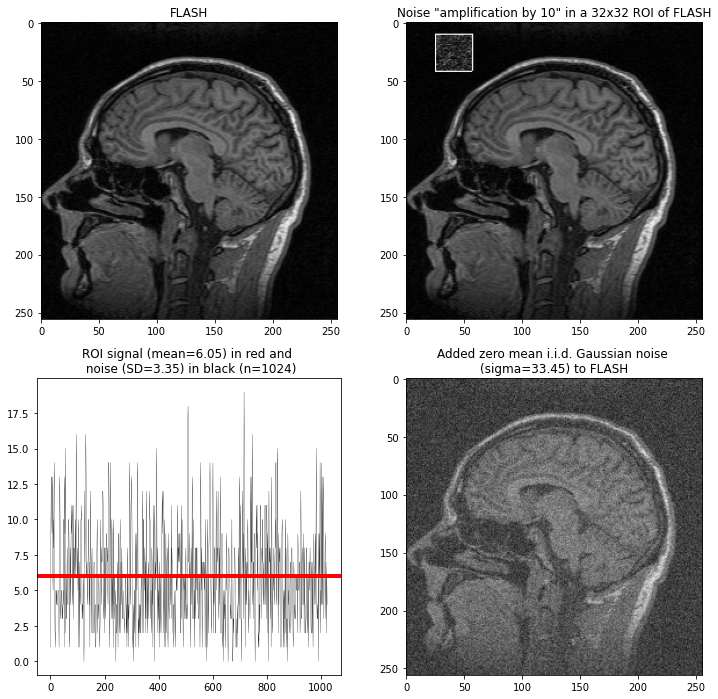

In [13]:
fig = plt.figure(figsize = [12, 12])
plt.subplot(2,2,1)
plt.imshow(flash_data, cmap='gray')
plt.title('FLASH')
plt.subplot(2,2,2)
plt.imshow(flash_data_upper_left, cmap='gray' )
plt.title('Noise "amplification by %d" in a %dx%d ROI of FLASH' % (a, d, d))
plt.subplot(2,2,3)
plt.plot(roi_bck, linewidth=0.25, color='k')
plt.axhline(y=roi_mean, linewidth=4, color='r')
plt.title('ROI signal (mean=%.2f) in red and \n noise (SD=%.2f) in black (n=%d)' % (roi_mean, roi_std, d*d))
plt.subplot(2,2,4)
plt.imshow(noisy_flash, cmap='gray' )
plt.title('Added zero mean i.i.d. Gaussian noise \n(sigma=%.2f) to FLASH' % (std))

plt.show()

# Uncomment and adjust the path if you want to save the figure to disk as a .png file

#fig.savefig('%s/prj/BMED360/results/flash_and_additive_zero_mean_iid_gaussian_noise.png' % (home),
#            transparent=False, dpi=300, bbox_inches="tight")

# Read, display and describe training masks and ROI mask 

#### **Training masks** (in our context) are images with manually delineated regions (labels) where each region is color-coded (or have a unique label-specific value) and denote a specific tissue type. Other terms for training masks are *data labeling*, or *data annotation* - see also [wikipedia](https://en.wikipedia.org/wiki/List_of_manual_image_annotation_tools).

#### These delineations (training, data labeling, or tissue sampling) are performed using an underlying MR image (=data, e.g. a FLASH channel image) guiding the annotation. The underlying image should be spatially informative regarding the signal intensities and localization of the tissue-specific pixels or voxels. The training mask is thus (per construction), spatially aligned (*coregistered*) with the data. To obtain the tissue specific feature *vectors* from multispectral data, the training mask is projected on all the channel images in a predefined order, defining the feature vector components (say, FLASH, DESS, FISP and PSIF).

#### With proper domain knowledge and software this training procedure can be relatively fast and accurate, but subject to inter and intra-operator variation.

In [14]:
fn_train = '%s/flash_060_training_mask_6cla.png' % (mydata)
fn_roi = '%s/flash_060_brain_mask.png' % (mydata)

## Read .png files using Matplotlib

`?plt.imread`

In [15]:
train_msk = plt.imread(fn_train)
roi_msk = plt.imread(fn_roi)

print('train_msk.dtype:', train_msk.dtype)
print('roi_msk.dtype:', roi_msk.dtype)
print('train_msk.shape:', train_msk.shape)
print('roi_msk.shape:', roi_msk.shape)
print('train_msk.min , max:', train_msk.min(), ',', train_msk.max())

train_msk.dtype: float32
roi_msk.dtype: float32
train_msk.shape: (256, 256, 3)
roi_msk.shape: (256, 256, 3)
train_msk.min , max: 0.0 , 1.0


## Scale the mask images to uint8 RGB images, i.e. R,G,B $\in$ {0,...,255}

In [16]:
train_msk = np.uint8(train_msk*255.0)
roi_msk = np.uint8(roi_msk*255.0)
print('train_msk.min:', train_msk.min(), ',', 'train_msk.max:', train_msk.max())

train_msk.min: 0 , train_msk.max: 255


## Display training mask and ROI mask (mask that covers the region of interest)

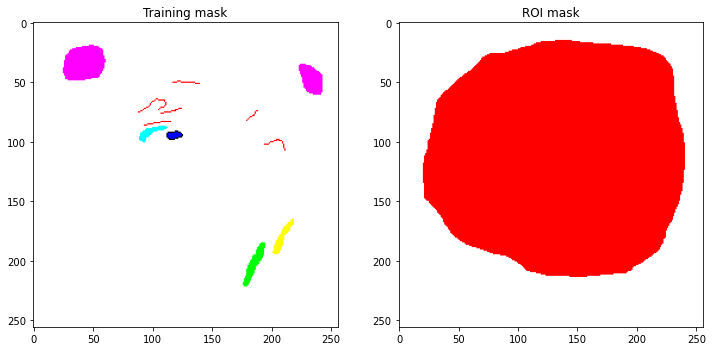

In [17]:
%matplotlib inline
fig = plt.figure('Showing the training mask and the ROI mask', figsize = [12, 7])
plt.subplot(1,2,1)
plt.imshow(train_msk)
plt.title('Training mask')
plt.subplot(1,2,2)
plt.imshow(roi_msk)
plt.title('ROI mask')
plt.show()

**Print the RGB-values in the middle of the ROI mask (excpected to be red = [255, 0, 0])**

In [18]:
row = np.uint8(np.ceil(roi_msk.shape[0]/2))  # row of target pixel location
col = np.uint8(np.ceil(roi_msk.shape[1]/2))  # column
v = roi_msk[row, col,:] # RGB-value at this pixel-location 
print('roi_msk[%d, %d,:] =' % (row, col)); print(v)

roi_msk[128, 128,:] =
[255   0   0]


### Make a new binary uint8 matrix with value 1 in each of the predefined tissue types, and 0 else

**Make a new binary uint8 matrix ("targ") where we assign 0 (black) to all pixel locations outside the training mask and 1 (white) to all pixel locations for which a tissue type is labeled (target)**<br>

- I the color-coded training mask white (=[255,255,255]) is used to represent background.<br>

We will use `np.all` which can be further explained by typing `?np.all` in a code cell, or see [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.all.html)

In [19]:
#?np.all

In [20]:
targ = 1 - np.all(train_msk == [255,255,255], axis=2).astype(np.uint8)
targ_roi = 1 - np.all(roi_msk == [255,255,255], axis=2).astype(np.uint8)
print('train_msk.shape', train_msk.shape)
print('targ.shape', targ.shape)

train_msk.shape (256, 256, 3)
targ.shape (256, 256)


## Display color-coded training mask and corresponding binary masks for labelled pixels and ROI pixels, respectively

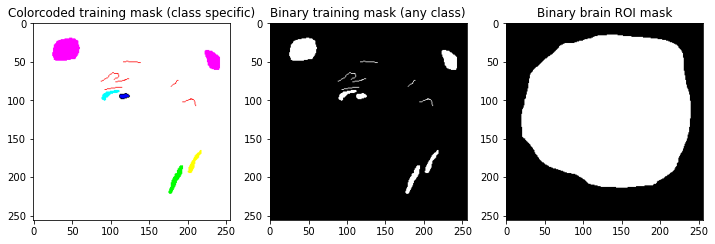

In [21]:
%matplotlib inline
fig = plt.figure(figsize = [12, 7])
plt.subplot(1,3,1)
plt.imshow(train_msk)
plt.title("Colorcoded training mask (class specific)")
plt.subplot(1,3,2)
plt.imshow(targ,cmap='gray')
plt.title("Binary training mask (any class)")
plt.subplot(1,3,3)
plt.imshow(targ_roi, cmap='gray')
plt.title("Binary brain ROI mask")
plt.show()

## Compute number of pixel occurences for each distinct color (i.e. number of samples in each class) in descending order

We can use `Counter` from [collections](https://docs.python.org/2/library/collections.html)

In [22]:
from collections import Counter
Counter([tuple(colors) for i in train_msk for colors in i]).most_common()

[((255, 255, 255), 63519),
 ((255, 0, 255), 1250),
 ((0, 255, 0), 250),
 ((255, 255, 0), 170),
 ((255, 0, 0), 136),
 ((0, 255, 255), 129),
 ((0, 0, 255), 51),
 ((0, 0, 0), 31)]

## Make grayscale-encoded training mask for each of the tissue classes 

**We can also display a grayscale training mask derived from the color-coded mask using [OpenCV](https://docs.opencv.org) and the transform [COLOR_RGB2GRAY](https://programtalk.com/python-examples/cv2.COLOR_RGB2GRAY)**

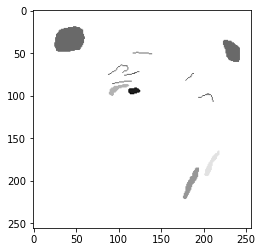

In [23]:
%matplotlib inline
train_msk_grey = cv2.cvtColor(train_msk, cv2.COLOR_RGB2GRAY)
plt.imshow(train_msk_grey, cmap='gray')
plt.show()

**Compute number of pixel occurences for each gray level (i.e. number of pixels in each class) in the grayscale training mask, and in descending order**

In [24]:
a = train_msk_grey.flatten()
unique, counts = np.unique(a, return_counts=True)
d = dict(zip(unique, counts))
sorted_by_counts = sorted(d.items(), key=lambda v: v[1], reverse=True)  # by second element
sorted_by_counts

[(255, 63519),
 (105, 1250),
 (150, 250),
 (226, 170),
 (76, 136),
 (179, 129),
 (29, 51),
 (0, 31)]

**NOTE:** In the color-coding in the traing mask (and in the grayscale mask) the RGB value [0,0,0] and grayscale value 0, respectively are shown as black (in total 31 pixels) and do not correspond to any of the pre-defined classes. This is **an error in the manual labeling** of tissue types and should be mapped to background, i.e. [255,255,255] and 0, respectively.

> **$\rightarrow$ Your turn!**
>
> - Find these erroneous assignments of pixels to black, diplay these, and make a corrected training mask where these pixels are assigned to background (white)<br>(as made implicitly further down in this notebook)

In [25]:
# Your code:

## Superimpose color-code training mask on the gray level FLASH channel image

**Here, using a "brute force" pixel loop  ...**

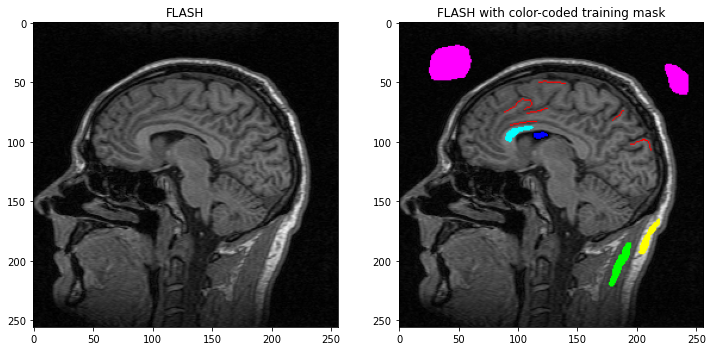

In [26]:
%matplotlib inline
# Scale the intensity in FLASH to a maximum of mymax to keep data within a uint8 (0-255) range
mymax = 200
flash_channel = dat[:, :, 0].squeeze()   # dat[:,:,0] is the FLASH channel
flash_channel = np.flip(flash_channel.T, 0)  # This numpy matrix manipulation step is explained later
flash_max = mymax * (flash_channel/flash_channel.max())
nrow, ncol = flash_max.shape
r = min(flash_channel.max(), 255) / mymax  # Scaling for the superimposed gray-scale pixels

# Define the RGB / grey-level composite (overlay) uint8 image
# by returning a new array of given shape and type, filled with zeros
flash_train_rgb = np.zeros(shape=(nrow,ncol,3), dtype=np.uint8)

# Loop over all pixels (this is brute force)
for i in range(nrow):
    for j in range(ncol):
        # Check if pixel coordinate is member of a tissue mask (white)
        if (targ[i,j] == 1):
           # Keep the mask RGB color (using RGB values in {0,,,.255}) at this location         
            for k in range(3):
                flash_train_rgb[i,j,k] = train_msk[i,j,k]
        else:
            # Make a gray-level pixel according to the signal intensity in rescaled FLASH
            for k in range(3):
                flash_train_rgb[i,j,k] = np.uint8(np.ceil(flash_max[i,j]*r))
                
fig = plt.figure(figsize = [12, 7])
plt.subplot(1,2,1)
plt.imshow(flash_max, cmap='gray'), plt.title('FLASH')
plt.subplot(1,2,2)
plt.imshow(flash_train_rgb), plt.title('FLASH with color-coded training mask')
plt.show()

# uncomment and adjust path if you want to save the figure to disk as .png file

#fig.savefig('%s/prj/BMED360/results/flash_with_training_mask_6_classes.png' % (home),
#            transparent=False, dpi=300, bbox_inches="tight")

#  Find all pixels for which the RGB tuples correspond to a class label

- **Color-coding of the tissue types** is typically used in the manual labeling (delineation) of pixels as they are displayed in e.g. the FLASH channel - pixels that are selected as representatives for the given tissue class. <br>


- There are a large collection of programs and software packages that can be used for such image-guided training. Today, a good choice could be __[ITK-SNAP](http://www.itksnap.org)__.


- See [Annotation of Medical Image Data](https://link.springer.com/content/pdf/10.1007%2F978-3-319-49644-3_4.pdf) for a comprehensive overview. You can also consult [this one](https://www.cogitotech.com/services/image-annotation) for general image annotation (as a service).

We have given the following color-coding of pre-defined tissue types:

In [27]:
AIR = [255,0,255] # Magenta 
GM  = [255,0,0]   # Red 
WM  = [0,255,255] # Cyan 
CSF = [0,0,255]   # Blue 
MUS = [0,255,0]   # Green 
FAT = [255,255,0] # Yellow 

ERR = [0,0,0] # Black
BCK = [255,255,255] # White (background)

**One possible procedure:** 

Loop through all classes (tissue types) and, for a given class, find all pixels for which the training mask value is equal to the class label (i.e. its RGB color triple).<br>
More specifically:

- Define for each class $k=1, \ldots, K$ (where $K$ is number of predefined classes), a 2D array having 1 in the pixel locations for which the pixel value is equal to the RGB mask value of $k$, otherwise 0. 
- Count the number of non-zero occurences to find the total number of pixels belonging tissue type $k$.

In [28]:
air = np.all(train_msk == AIR, axis=2).astype(np.int)
n_air = np.count_nonzero(air)
print('n_air =', n_air)

gm = np.all(train_msk == GM, axis=2).astype(np.int)
n_gm = np.count_nonzero(gm)
print('n_gm =', n_gm)

wm = np.all(train_msk == WM, axis=2).astype(np.int)
n_wm = np.count_nonzero(wm)
print('n_wm =', n_wm)

csf = np.all(train_msk == CSF, axis=2).astype(np.int)
n_csf = np.count_nonzero(csf)
print('n_csf =', n_csf)

mus = np.all(train_msk == MUS, axis=2).astype(np.int)
n_mus = np.count_nonzero(mus)
print('n_mus =', n_mus)

fat = np.all(train_msk == FAT, axis=2).astype(np.int)
n_fat = np.count_nonzero(fat)
print('n_fat =', n_fat)

err = np.all(train_msk == ERR, axis=2).astype(np.int)
n_err = np.count_nonzero(err)
print('\nn_err =', n_err)

bck = np.all(train_msk == BCK, axis=2).astype(np.int)
n_bck = np.count_nonzero(bck)
print('n_bck =', n_bck)

n_air = 1250
n_gm = 136
n_wm = 129
n_csf = 51
n_mus = 250
n_fat = 170

n_err = 31
n_bck = 63519


/var/folders/y0/6krmxw152qjflvfhkn0bn4r40000gn/T/ipykernel_2499/2195963030.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  air = np.all(train_msk == AIR, axis=2).astype(np.int)
/var/folders/y0/6krmxw152qjflvfhkn0bn4r40000gn/T/ipykernel_2499/2195963030.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to r

Or, more compact, using a (key, value) **dictionary**  (well explained in [geeksforgeeks](https://www.geeksforgeeks.org/python-dictionary)) :

In [29]:
# Dictionary
col_code = {
    'AIR': [255,0,255],  # Magenta 
    'GM':  [255,0,0],    # Red 
    'WM':  [0,255,255],  # Cyan 
    'CSF': [0,0,255],    # Blue 
    'MUS': [0,255,0],    # Green 
    'FAT': [255,255,0],  # Yellow 
    'ERR': [0,0,0],      # Black
    'BCK': [255,255,255] # White (background)
}

Now, using a dictionary. At the same time we give an example of how to construct a sequence of commands being program sentences with specific parameters and their values, followed by execution of these commands using [`exec`](https://www.geeksforgeeks.org/exec-in-python)

In [30]:
# Make separate masks for each class

for key in col_code.keys():
    keyl = key.lower()  # lower-case letters
    cmd1 = '%s = np.int16(np.all(train_msk == %s, axis=2))' % (keyl, key); print(cmd1); exec(cmd1)
    cmd2 = 'n_%s = np.count_nonzero(%s)' % (keyl, keyl); print(cmd2); exec(cmd2)
    cmd3 = 'print("n_%s =", n_%s)' % (keyl, keyl); print(cmd3); exec(cmd3)

air = np.int16(np.all(train_msk == AIR, axis=2))
n_air = np.count_nonzero(air)
print("n_air =", n_air)
n_air = 1250
gm = np.int16(np.all(train_msk == GM, axis=2))
n_gm = np.count_nonzero(gm)
print("n_gm =", n_gm)
n_gm = 136
wm = np.int16(np.all(train_msk == WM, axis=2))
n_wm = np.count_nonzero(wm)
print("n_wm =", n_wm)
n_wm = 129
csf = np.int16(np.all(train_msk == CSF, axis=2))
n_csf = np.count_nonzero(csf)
print("n_csf =", n_csf)
n_csf = 51
mus = np.int16(np.all(train_msk == MUS, axis=2))
n_mus = np.count_nonzero(mus)
print("n_mus =", n_mus)
n_mus = 250
fat = np.int16(np.all(train_msk == FAT, axis=2))
n_fat = np.count_nonzero(fat)
print("n_fat =", n_fat)
n_fat = 170
err = np.int16(np.all(train_msk == ERR, axis=2))
n_err = np.count_nonzero(err)
print("n_err =", n_err)
n_err = 31
bck = np.int16(np.all(train_msk == BCK, axis=2))
n_bck = np.count_nonzero(bck)
print("n_bck =", n_bck)
n_bck = 63519


## Using Numpy's `where` to find occurences that match given criteria related to an RGB image array 

Alternatively, you can use Numpy's __[where](https://stackoverflow.com/questions/34667282/numpy-where-detailed-step-by-step-explanation-examples)__ for making
**a compsite grey level training mask according to the class label enumeration**<br>
 AIR=1, GM=2, WM=3, CSF=4, MUS=5, FAT=6

In [31]:
# Using np.where() to find pixel locations for each class of the 6 valid tissue types
col_code_sub = {a: col_code[a] for a in ['AIR','GM','WM', 'CSF', 'MUS', 'FAT'] if a in col_code}
cc = list(col_code_sub.keys())

train_msk_1_6 = np.zeros(train_msk[:,:,0].shape, dtype=np.uint8)  # Initialize with background zero

for n, val in enumerate(col_code_sub.values()):
    m = cc[n].lower()
    mm = np.where((train_msk[:,:,0] == val[0]) & (train_msk[:,:,1] == val[1]) & (train_msk[:,:,2] == val[2]))
    train_msk_1_6[mm[0],mm[1]] = (n+1)  # # mm[0]: rows, mm[1]: cols
    print('cla_%d (%s) n=%d \t -> accum training samples: %d' % (n+1, m , len(mm[0]), np.count_nonzero(train_msk_1_6)))

cla_1 (air) n=1250 	 -> accum training samples: 1250
cla_2 (gm) n=136 	 -> accum training samples: 1386
cla_3 (wm) n=129 	 -> accum training samples: 1515
cla_4 (csf) n=51 	 -> accum training samples: 1566
cla_5 (mus) n=250 	 -> accum training samples: 1816
cla_6 (fat) n=170 	 -> accum training samples: 1986


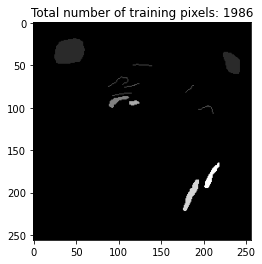

In [32]:
%matplotlib inline
#train_msk_1_6 = 1*air + 2*gm + 3*wm + 4*csf + 5*mus + 6*fat
plt.imshow(train_msk_1_6, cmap='gray')
plt.title('Total number of training pixels: %d' % np.count_nonzero(train_msk_1_6))
plt.show()

# Unbalanced classes

**Check class distribution  - which is unbalanced (see e.g. [Brownlee](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset) and [`imbalanced-learn`](https://github.com/scikit-learn-contrib/imbalanced-learn/blob/master/README.rst))**

In [33]:
a = train_msk_1_6.flatten()
unique, counts = np.unique(a, return_counts=True)
dict(zip(unique, counts))

{0: 63550, 1: 1250, 2: 136, 3: 129, 4: 51, 5: 250, 6: 170}

# Save training mask as a NIFTI image

**Save `training_mask_1_6` as int16 NIFTI image and use header information (affine) from the multispectral image**

In [34]:
fn_tmsk = '../data/training_mask_1_6.nii.gz'
# We have to flip and transpose to align the mask to the multispectral image
training_mask_1_6 = np.flip(train_msk_1_6, 0).T 
# and make a 4-dim matrix with z-dim and spectral-dim both =1 to match the img (fn_multispectral)
nrow = training_mask_1_6.shape[0]
ncol = training_mask_1_6.shape[1]
training_mask_1_6 = np.reshape(training_mask_1_6, (nrow, ncol, 1, 1))
tmsk = nib.Nifti1Image(np.int16(training_mask_1_6), img.affine )
nib.save(tmsk, fn_tmsk)

Print characteristics of the NIFT training mask image

In [35]:
print('shape of training mask image = ', tmsk.header.get_data_shape())
print('units = ', tmsk.header.get_xyzt_units())
print('voxel size = ', tmsk.header.get_zooms())
print('dtype = %s' % tmsk.header.get_data_dtype())
tmsk_data = tmsk.get_fdata()
print('min = %.1f' % tmsk_data.min())
print('max = %.1f' % tmsk_data.max())
print('number of channels =', tmsk.shape[-1])
# Collaps the singular (z-)dimension
tmsk_dat = np.uint16(tmsk_data.squeeze())
print('shape of tmsk dat = ',tmsk_dat.shape)
print('dtype of tmsk dat = ',tmsk_dat.dtype)

shape of training mask image =  (256, 256, 1, 1)
units =  ('unknown', 'unknown')
voxel size =  (1.0, 1.0, 1.4, 1.0)
dtype = int16
min = 0.0
max = 6.0
number of channels = 1
shape of tmsk dat =  (256, 256)
dtype of tmsk dat =  uint16


**Check  results!** (e.g. using FreeSurfer's [freeview](https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial/OutputData_freeview))

![tmsk_on_channels_freeview](assets/tmsk_on_channels_freeview_pptx.png)

or using nilearn's `plotting`

/Users/arvid/opt/anaconda3/envs/tumor-cnr/lib/python3.8/site-packages/nilearn/plotting/displays.py:101: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  im = getattr(ax, type)(data_2d.copy(),
/Users/arvid/opt/anaconda3/envs/tumor-cnr/lib/python3.8/site-packages/nilearn/plotting/displays.py:79: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  self.ax.axis(self.get_object_bounds())


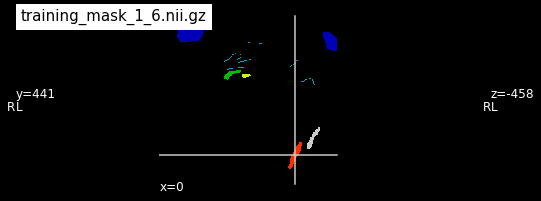

In [36]:
%matplotlib inline
plotting.plot_epi(fn_tmsk, title='training_mask_1_6.nii.gz')
plt.show()

or use `imshow` from Matplotlib

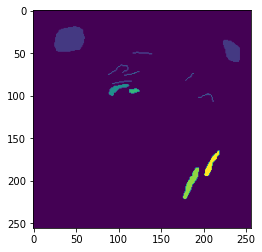

In [37]:
plt.imshow(train_msk_1_6)
plt.show()

# Save ROI brain mask as NIFTI file

**Store `brain_roi_mask` as an int16 NIFTI image and copy header information (affine) from the multispectral image**

In [38]:
fn_roi = '../data/brain_roi_mask.nii.gz'
#roi = np.all(roi_msk == [255,0,0], axis=1).astype(np.int)
#n_roi = np.count_nonzero(roi)
#print('n_roi =', n_roi)
# We have to flip and transpose to align the mask to the multispectral image
trag_roi = np.flip(targ_roi, 0).T
# and make a 4-dim matrix with z-dim and spectral-dim both =1 to match the mult
nrow = targ_roi.shape[0]
ncol = targ_roi.shape[1]
brain_roi = np.reshape(trag_roi, (nrow, ncol, 1, 1))
rmsk = nib.Nifti1Image(np.int16(brain_roi), img.affine )
nib.save(rmsk, fn_roi)

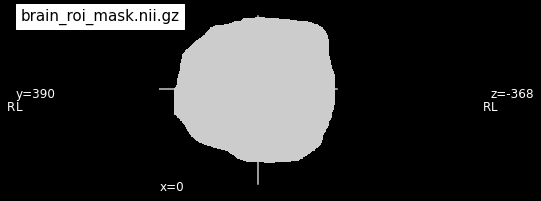

In [39]:
%matplotlib inline
plotting.plot_epi(fn_roi, title='brain_roi_mask.nii.gz')
plt.show()

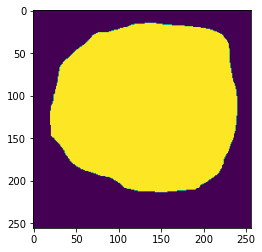

In [40]:
plt.imshow(targ_roi.squeeze())
plt.show()

**Visuell sjekk i Freeview (FreeSurfer):**

![tmsk_roi_on_flash_freeview](assets/tmsk_and_roi_on_flash_freeview.png)

## Display labelled pixels for each of the six classes as separat binary masks

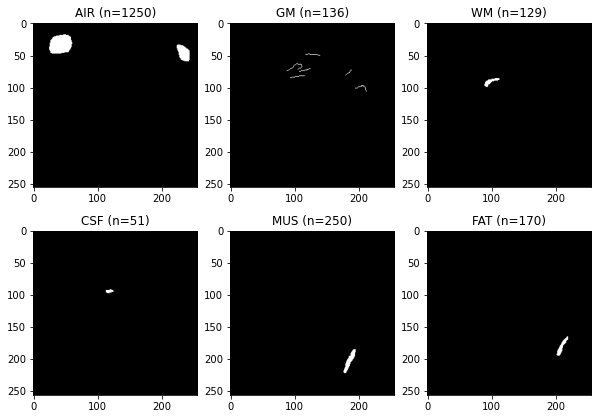

In [41]:
%matplotlib inline
fig = plt.figure('Showing the training masks', figsize = [10, 7])
plt.tight_layout
fonts = 12
plt.subplot(2,3,1), plt.title('AIR (n=%d)' % (n_air), fontsize=fonts)
plt.imshow(air, cmap='gray')
plt.subplot(2,3,2), plt.title('GM (n=%d)' % (n_gm), fontsize=fonts)
plt.imshow(gm, cmap='gray')
plt.subplot(2,3,3), plt.title('WM (n=%d)' % (n_wm), fontsize=fonts)
plt.imshow(wm, cmap='gray')
plt.subplot(2,3,4), plt.title('CSF (n=%d)' % (n_csf), fontsize=fonts)
plt.imshow(csf, cmap='gray')
plt.subplot(2,3,5), plt.title('MUS (n=%d)' % (n_mus), fontsize=fonts)
plt.imshow(mus, cmap='gray')
plt.subplot(2,3,6), plt.title('FAT (n=%d)' % (n_fat), fontsize=fonts)
plt.imshow(fat, cmap='gray')
plt.show()

# Find tissue type and sequence-specific MRI signal intensities   - data matrix (X ) and labels (y)

In [42]:
# Get data for each 2D channel image
p = len(chn_names)
flash_chn_dat = dat[:, :, 0].squeeze()
dess_chn_dat = dat[:, :, 1].squeeze()
fisp_chn_dat = dat[:, :, 2].squeeze()
psif_chn_dat = dat[:, :, 3].squeeze()

**OBS! Check your data (correct image orientation and geometric correspondence between training mask and pixel values - i.e. the image data!)**

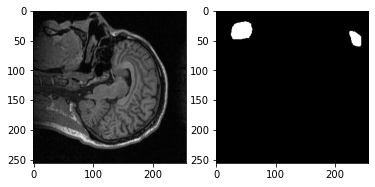

In [43]:
%matplotlib inline
plt.subplot(1,2,1)
plt.imshow(flash_chn_dat, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(air, cmap='gray')
plt.show()

**We will need to transpose the channel image and flip the image matrix vertically**

Transpose (`.T`):

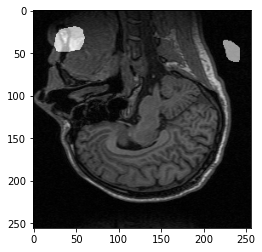

In [44]:
%matplotlib inline
plt.imshow(flash_chn_dat.T + 255*air, cmap='gray')
plt.show()

Flip vertically (`np.flip(X,0)`):

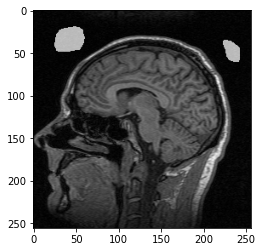

In [45]:
%matplotlib inline
plt.imshow(np.flip(flash_chn_dat.T, 0) + 255*air, cmap='gray')
plt.show()

In [46]:
flash_chn = np.flip(flash_chn_dat.T, 0)
dess_chn = np.flip(dess_chn_dat.T, 0)
fisp_chn = np.flip(fisp_chn_dat.T, 0)
psif_chn = np.flip(psif_chn_dat.T, 0)

**Design a function that defines class-specific p-dimensional feature matrix (data matrix)  <br> for a given class k $\in$ {air, gm, wm, csf, mus, fat}** 

In [47]:
def make_feature_matrix(k):
    '''
    Ex.
    A = make_feature_matrix(air)
    A.shape
    '''
    M = np.column_stack(
        (flash_chn[k == 1], 
         dess_chn[k == 1],
         fisp_chn[k == 1],
         psif_chn[k == 1]))
    return M

Test this function on the air/bone class (AIR) and compute the noise in each channel, i.e. SD(air)

In [48]:
# Test on the AIR class (computing SD, expressing noise level)

A = make_feature_matrix(air)
print('Noise (SD) in FLASH: %.2f (n=%d)' % (A[:,0].std(), A.shape[0]))
print('Noise (SD) in DESS : %.2f (n=%d)' % (A[:,1].std(), A.shape[0]))
print('Noise (SD) in FSIP : %.2f (n=%d)' % (A[:,2].std(), A.shape[0]))
print('Noise (SD) in PSIF : %.2f (n=%d)' % (A[:,3].std(), A.shape[0]))

Noise (SD) in FLASH: 3.47 (n=1250)
Noise (SD) in DESS : 4.88 (n=1250)
Noise (SD) in FSIP : 4.47 (n=1250)
Noise (SD) in PSIF : 3.44 (n=1250)


# Read training data set (X and y) to a Pandas dataframe

**The function `make_feature_matrix()` can be used to construct class-specific Pandas data frames where the features are <br> MRI signal intensities (SI) in each channel in the multispectral image, i.e. $X$** 

**Uses [`DataFrame.insert()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.insert.html) to add the class label ($y$) at the end.**

In [49]:
dfAIR = pd.DataFrame(make_feature_matrix(air), columns = chn_names)
dfAIR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   FLASH   1250 non-null   uint16
 1   DESS    1250 non-null   uint16
 2   FISP    1250 non-null   uint16
 3   PSIF    1250 non-null   uint16
dtypes: uint16(4)
memory usage: 9.9 KB


In [50]:
dfAIR.insert(p, 'Class', 'AIR')
dfAIR.head(3)

,FLASH,DESS,FISP,PSIF,Class
0,5,6,2,2,AIR
1,5,6,4,10,AIR
2,2,5,2,9,AIR


In [51]:
dfAIR.tail(3)

,FLASH,DESS,FISP,PSIF,Class
1247,9,10,6,2,AIR
1248,12,6,14,5,AIR
1249,11,7,16,5,AIR


In [52]:
dfGM = pd.DataFrame(make_feature_matrix(gm),  columns = chn_names)
dfGM.insert(p, 'Class', 'GM')

In [53]:
dfWM = pd.DataFrame(make_feature_matrix(wm),  columns = chn_names)
dfWM.insert(p, 'Class', 'WM')

In [54]:
dfCSF = pd.DataFrame(make_feature_matrix(csf),  columns = chn_names)
dfCSF.insert(p, 'Class', 'CSF')

In [55]:
dfMUS = pd.DataFrame(make_feature_matrix(mus),  columns = chn_names)
dfMUS.insert(p, 'Class', 'MUS')

In [56]:
dfFAT = pd.DataFrame(make_feature_matrix(fat),  columns = chn_names)
dfFAT.insert(p, 'Class', 'FAT')
dfFAT.head(3)

,FLASH,DESS,FISP,PSIF,Class
0,267,56,109,166,FAT
1,287,53,148,214,FAT
2,245,64,109,152,FAT


In [57]:
dfFAT.tail(3)

,FLASH,DESS,FISP,PSIF,Class
167,229,34,112,135,FAT
168,235,32,117,159,FAT
169,251,31,125,172,FAT


## Concatenate the tissue-specific data frames to a complete training dataset (dfT)

In [58]:
frames = [dfAIR, dfGM, dfWM, dfCSF, dfMUS, dfFAT]
dfT = pd.concat(frames, ignore_index=True)

Sjekk første tre og siste tre datapunkter i treningsdatasettet`dfT`

In [59]:
dfT.head(3)

,FLASH,DESS,FISP,PSIF,Class
0,5,6,2,2,AIR
1,5,6,4,10,AIR
2,2,5,2,9,AIR


In [60]:
dfT.tail(3)

,FLASH,DESS,FISP,PSIF,Class
1983,229,34,112,135,FAT
1984,235,32,117,159,FAT
1985,251,31,125,172,FAT


#  Save training data set (X,y) as  csv-file in the `data/mri` -directory

In [61]:
dfT.to_csv('../data/multispectral_mri_training_data.csv', index=False)

#  Explorative Data Analys (EDA)  regarding the training data set (X, y)
**Descriptive statistics & graphics**

In [62]:
print(dfT.shape[0])
dfT.info()

1986
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   FLASH   1986 non-null   uint16
 1   DESS    1986 non-null   uint16
 2   FISP    1986 non-null   uint16
 3   PSIF    1986 non-null   uint16
 4   Class   1986 non-null   object
dtypes: object(1), uint16(4)
memory usage: 31.2+ KB


In [63]:
# Make a list of the different class-labels in the training dataset
dfT['Class'].unique().tolist()

['AIR', 'GM', 'WM', 'CSF', 'MUS', 'FAT']

In [64]:
# Class-specific statistics accross the different features (channels)
dfT.groupby('Class').describe(percentiles = [0.5]).round(2).T

Class            AIR     CSF     FAT      GM     MUS      WM
FLASH count  1250.00   51.00  170.00  136.00  250.00  129.00
      mean      6.05   29.20  264.44  112.73  101.34  162.72
      std       3.47    6.67   40.78   11.18    8.81    6.87
      min       0.00   13.00  140.00   91.00   79.00  132.00
      50%       6.00   30.00  271.00  112.00  103.00  163.00
      max      19.00   46.00  338.00  152.00  123.00  178.00
DESS  count  1250.00   51.00  170.00  136.00  250.00  129.00
      mean      6.92  129.29   45.18  127.43   50.77  117.88
      std       4.88   70.86    9.18   19.70    7.18    6.72
      min       0.00   42.00   24.00  100.00   28.00  101.00
      50%       6.00  110.00   45.00  124.50   51.00  118.00
      max      26.00  258.00   71.00  217.00   70.00  137.00
FISP  count  1250.00   51.00  170.00  136.00  250.00  129.00
      mean      6.55   71.04  133.69  171.60  103.37  187.75
      std       4.47   12.17   25.82   16.72   21.55    8.11
      min       0.00   50.00   72.00  127.00   34.00  174.00
      50%       5.00   70.00  135.00  172.00  102.00  187.00
      max      26.00   99.00  185.00  221.00  144.00  209.00
PSIF  count  1250.00   51.00  170.00  136.00  250.00  129.00
      mean      6.00  285.41  152.31  154.75   45.33  112.36
      std       3.45  104.92   28.73   68.43   12.10   18.02
      min       0.00  104.00   68.00  103.00   19.00   66.00
      50%       6.00  324.00  154.00  126.00   45.00  113.00
      max      19.00  418.00  214.00  439.00   78.00  168.00

## Class-wise boxplot for each feature (channel)

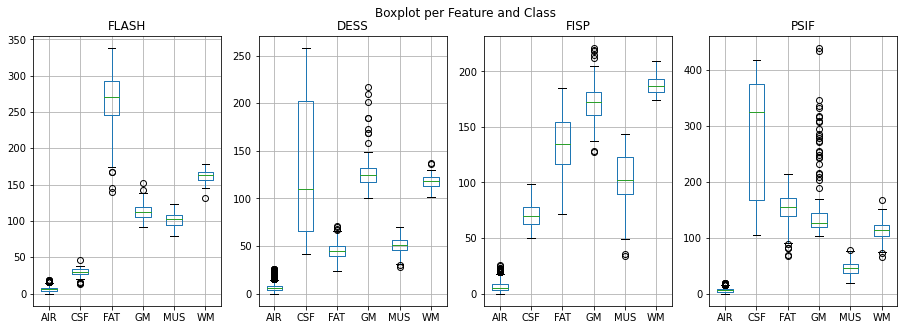

In [65]:
%matplotlib inline
fig, axes = plt.subplots(1,4, figsize=(15,5))
ax = axes.ravel()
for k, ch in enumerate(chn_names):
    dfT.boxplot(column=[ch], by='Class', ax=ax[k])
    ax[k].set_title(ch.upper())
    ax[k].set(xlabel="")
plt.suptitle("Boxplot per Feature and Class")    
plt.show()

## [Seaborn](https://seaborn.pydata.org) pairplot  - class-wise for each pair of channels

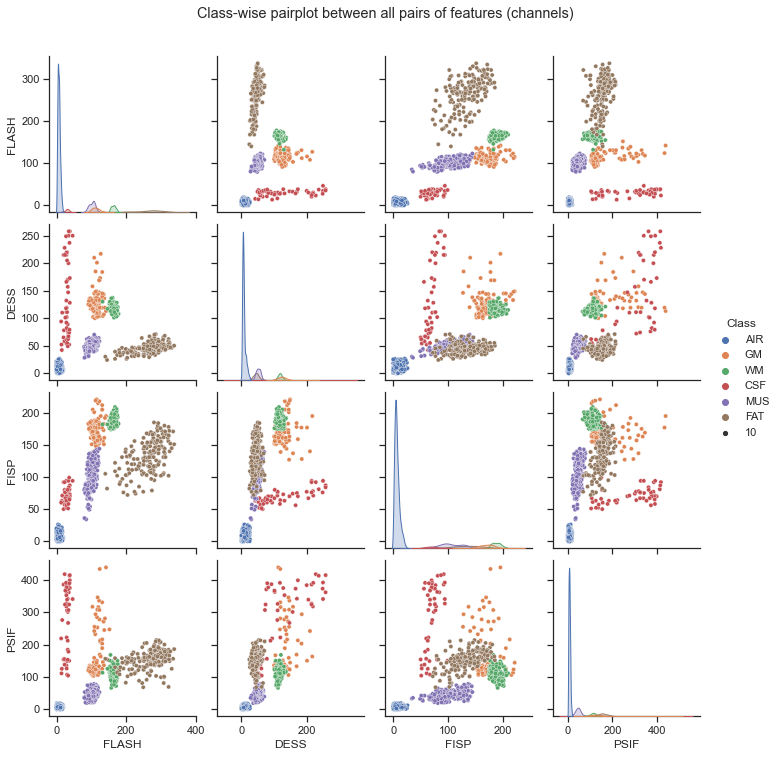

In [66]:
%matplotlib inline
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(dfT, hue="Class", vars = chn_names, plot_kws = {"size":10})
g.fig.suptitle("Class-wise pairplot between all pairs of features (channels)", y=1.05) 
plt.show()

# uncomment and adjust path if you want to save the figure to disk as a .png file

#g.savefig('%s/prj/BMED360/results/class_wise_pairplot_between_all_pairs_of_features_(channels).png' % (home),
#           transparent=False, dpi=300, bbox_inches="tight")

### Make a figure of tissue-specific SI-distributions (probability densities) for each of the channels

In [67]:
# Find global SI min and max for each channel across all tissue types for same x-scaling
mn1 = dfT['FLASH'].min(); mx1 = dfT['FLASH'].max() 
mn2 = dfT['DESS'].min(); mx2 = dfT['DESS'].max() 
mn3 = dfT['FISP'].min(); mx3 = dfT['FISP'].max() 
mn4 = dfT['PSIF'].min(); mx4 = dfT['PSIF'].max() 

/Users/arvid/opt/anaconda3/envs/tumor-cnr/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/arvid/opt/anaconda3/envs/tumor-cnr/lib/python3.8/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/arvid/opt/anaconda3/envs/tumor-cnr/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density p

/Users/arvid/opt/anaconda3/envs/tumor-cnr/lib/python3.8/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/arvid/opt/anaconda3/envs/tumor-cnr/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/arvid/opt/anaconda3/envs/tumor-cnr/lib/python3.8/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/arvid/opt/anaconda3/envs/tumor-cnr/lib/python3.8/site-packages/seaborn/distribut

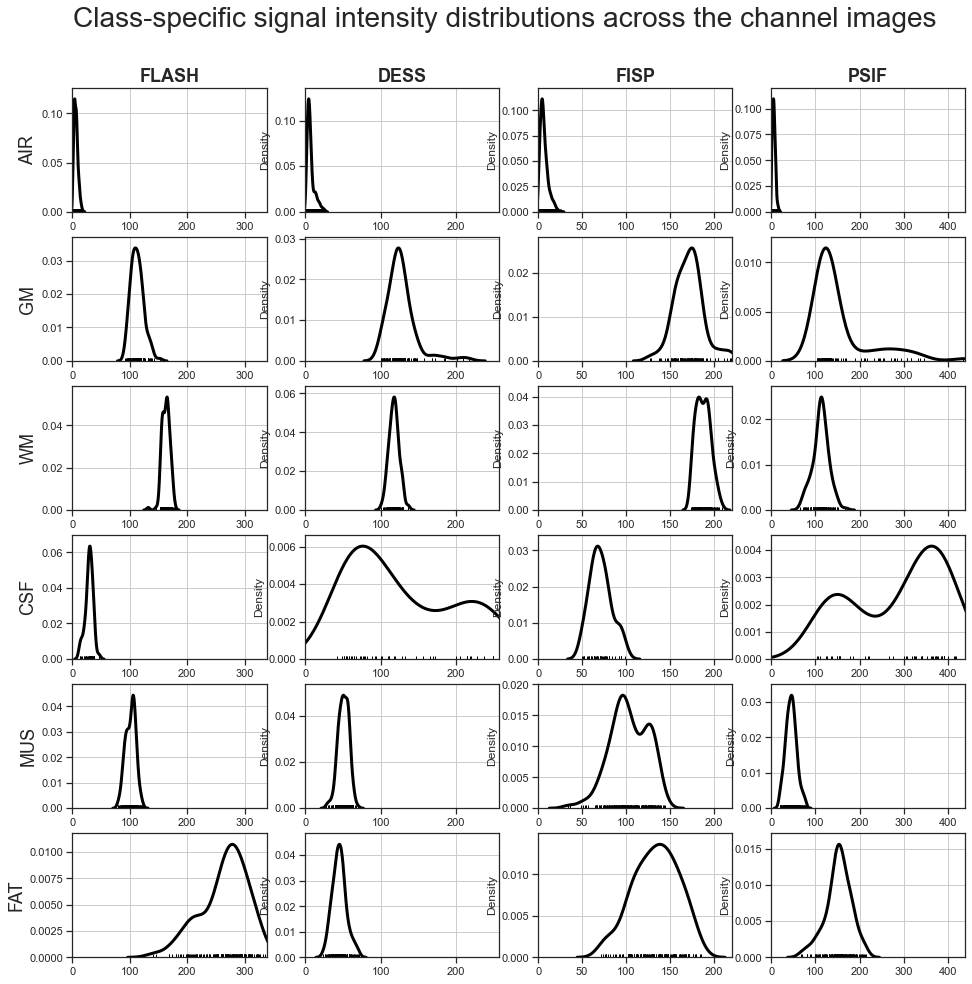

In [68]:
%matplotlib inline
# Make the 6 x 4 panels in the figure
fig, axes = plt.subplots(6, 4, figsize=(16, 16), sharex=False, sharey=False)
fig.suptitle("Class-specific signal intensity distributions across the channel images", 
             fontsize=28, y=0.95)   # y location of the text in figure coordinates

for k, cla in enumerate(class_names):
    sns.distplot(dfT.loc[dfT['Class']==cla.upper()].FLASH.values,
                 color="black", kde=True, rug=True, hist=False, kde_kws={"lw": 3},
                 ax=axes[k,0])
    axes[k,0].set_xlim(mn1,mx1); axes[k,0].grid(True)
    sns.distplot(dfT.loc[dfT['Class']==cla.upper()].DESS.values,
                 color="black", kde=True, rug=True, hist=False, kde_kws={"lw": 3},
                 ax=axes[k,1])
    axes[k,1].set_xlim(mn2,mx2); axes[k,1].grid(True)
    sns.distplot(dfT.loc[dfT['Class']==cla.upper()].FISP.values,
                 color="black", kde=True, rug=True, hist=False, kde_kws={"lw": 3},
                 ax=axes[k,2])
    axes[k,2].set_xlim(mn3,mx3); axes[k,2].grid(True)
    sns.distplot(dfT.loc[dfT['Class']==cla.upper()].PSIF.values,
                 color="black", kde=True, rug=True, hist=False, kde_kws={"lw": 3},
                 ax=axes[k,3])
    axes[k,3].set_xlim(mn4,mx4); axes[k,3].grid(True)

# Make proper labels for the channel columns
for ch, chn in enumerate(chn_names):
    axes[0,ch].set_title(chn.upper(), fontsize=18, fontweight="bold")

# Make proper labels for the tissue type row-names
for k, cla in enumerate(class_names):
    axes[k,0].set(ylabel= cla.upper())
    axes[k,0].yaxis.label.set_size(18)

plt.show()

# uncomment and adjust path if you want to save the figure to disk as a .pdf or a .png file

#fig.savefig('%s/prj/BMED360/results/class_specific_si_densities_across_channels.pdf' % (home))

#fig.savefig('%s/prj/BMED360/results/class_specific_si_densities_across_channels.png' % (home),
#           transparent=False, dpi=300, bbox_inches="tight")

## Make an interactive 3D scatterplot (do not work with Jupyter Lab)

**Define the combinations of classes and channels that can be used**

In [69]:
x1air = list(dfT.loc[dfT['Class']=='AIR'].FLASH.values)
x2air = list(dfT.loc[dfT['Class']=='AIR'].DESS.values)
x3air = list(dfT.loc[dfT['Class']=='AIR'].FISP.values)

x1gm = list(dfT.loc[dfT['Class']=='GM'].FLASH.values)
x2gm = list(dfT.loc[dfT['Class']=='GM'].DESS.values)
x3gm = list(dfT.loc[dfT['Class']=='GM'].FISP.values)

x1wm = list(dfT.loc[dfT['Class']=='WM'].FLASH.values)
x2wm = list(dfT.loc[dfT['Class']=='WM'].DESS.values)
x3wm = list(dfT.loc[dfT['Class']=='WM'].FISP.values)

x1csf = list(dfT.loc[dfT['Class']=='CSF'].FLASH.values)
x2csf = list(dfT.loc[dfT['Class']=='CSF'].DESS.values)
x3csf = list(dfT.loc[dfT['Class']=='CSF'].FISP.values)

x1mus = list(dfT.loc[dfT['Class']=='MUS'].FLASH.values)
x2mus = list(dfT.loc[dfT['Class']=='MUS'].DESS.values)
x3mus = list(dfT.loc[dfT['Class']=='MUS'].FISP.values)

x1fat = list(dfT.loc[dfT['Class']=='FAT'].FLASH.values)
x2fat = list(dfT.loc[dfT['Class']=='FAT'].DESS.values)
x3fat = list(dfT.loc[dfT['Class']=='FAT'].FISP.values)

Make a 3D scatterplot (can not be interactive using Jupyter Lab)

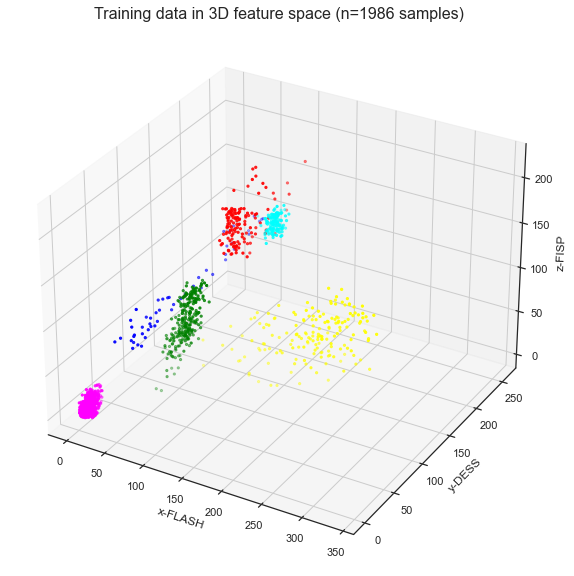

In [70]:
# Enables interactive 3D plot
#%matplotlib notebook 
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


# AIR = [255,0,255] # Magenta 
# GM  = [255,0,0]   # Red 
# WM  = [0,255,255] # Cyan 
# CSF = [0,0,255]   # Blue 
# MUS = [0,255,0]   # Green 
# FAT = [255,255,0] # Yellow 


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1air, x2air, x3air, c='magenta', marker='.')
ax.scatter(x1gm, x2gm, x3gm, c='red', marker='.')
ax.scatter(x1wm, x2wm, x3wm, c='cyan', marker='.')
ax.scatter(x1csf, x2csf, x3csf, c='blue', marker='.')
ax.scatter(x1mus, x2mus, x3mus, c='green', marker='.')
ax.scatter(x1fat, x2fat, x3fat, c='yellow', marker='.')

ax.set_xlabel('x-FLASH')
ax.set_ylabel('y-DESS')
ax.set_zlabel('z-FISP')

plt.title("Training data in 3D feature space (n=%d samples)" % (dfT.shape[0]), fontsize=16)
plt.show()

# $\rightarrow$ Your turn!

## Fill in the CNR-table for the multispectral MRI data

**Given 6 tissue-classes and 4 channels**

 - **Based on the tissue-specific signal intensity distributions for each of the MRI sequnces (channels) shown in the figures above, discuss:** 

    1.  Which channel will best discriminate / separate between GM and WM? 

    2.  Is it easy to distinguish between  `gray matter` and `muscle` in the FLASH channel?

    3.  Why do we find such a large variation in CSF signal intensites in the T2-weighted DESS channel?<br> 
  (hint: https://www.ajronline.org/doi/10.2214/AJR.05.0003)

 - **Write your results (graphs, tables, fugures) to a local directory on your computer** <br>
 
   (hint: make a folder outside your Git repository , e.g. $HOME/prj/BMED360/results, and add the following statement
   in the cell above, showing tissue-specific SI distributions (probability densities) for each of the channels: 
   
   ```python
   import os
   home = os.path.expanduser('~')
   
   fig.savefig('%s/prj/BMED360/results/class_specific_si_densities_across_channels.png' % (home), transparent=False, dpi=80, bbox_inches="tight")
   ```

   Moreover, save figures previously produced that illustrate data and results, in the same folder, i.e.
   
   ```python
   fig.savefig('%s/prj/BMED360/results/flash_dess_fisp_psif_channel_images.png' % (home),
   transparent=False, dpi=300, bbox_inches="tight")
   ```
   and
   ```python
   fig.savefig('%s/prj/ELMED219/results/flash_with_training_mask_6_classes.png' % (home),
   transparent=False, dpi=300, bbox_inches="tight")
   ``

- **Make a contrast-to-noise-ratio (CNR) tabel (dataframe) between each pair of tissue types and for each of the channels** <br>

     - Hint: We define the CNR between tissue type GM and tissue type WM in channel FLASH as: 
  
> CNR(GM,WM)$_{FLASH}$  =  abs(mean(GM)$_{FLASH}$ - mean(WM)$_{FLASH}$) / std(AIR)$_{FLASH}$

- Hint to compute the noise accross the set of channels:

```python
D = pd.read_csv('../data/mri/multispectral_mri_training_data.csv')

sigma_0 = np.zeros(len(chn_names))
for k, chn in enumerate(chn_names):
    sigma_0[k] = np.std(list(D.loc[D['Class']=='AIR'][chn].values)).round(3)

list(sigma_0)
```

- Hint to compute CNR(tissue_a, tissue_b, channel_chn) as a function: 

```python
def cnr(a,b,chn):
    s_0 = np.std(list(D.loc[D['Class']=='AIR'][chn].values))
    mu_a = np.mean(list(D.loc[D['Class']==a][chn].values))
    mu_b = np.mean(list(D.loc[D['Class']==b][chn].values))
    cnr_a_b = abs(mu_a - mu_b)/ s_0
    return cnr_a_b

cnr('AIR','GM','FLASH').round(2)
```

  - Fill in the table (or in a similar format):

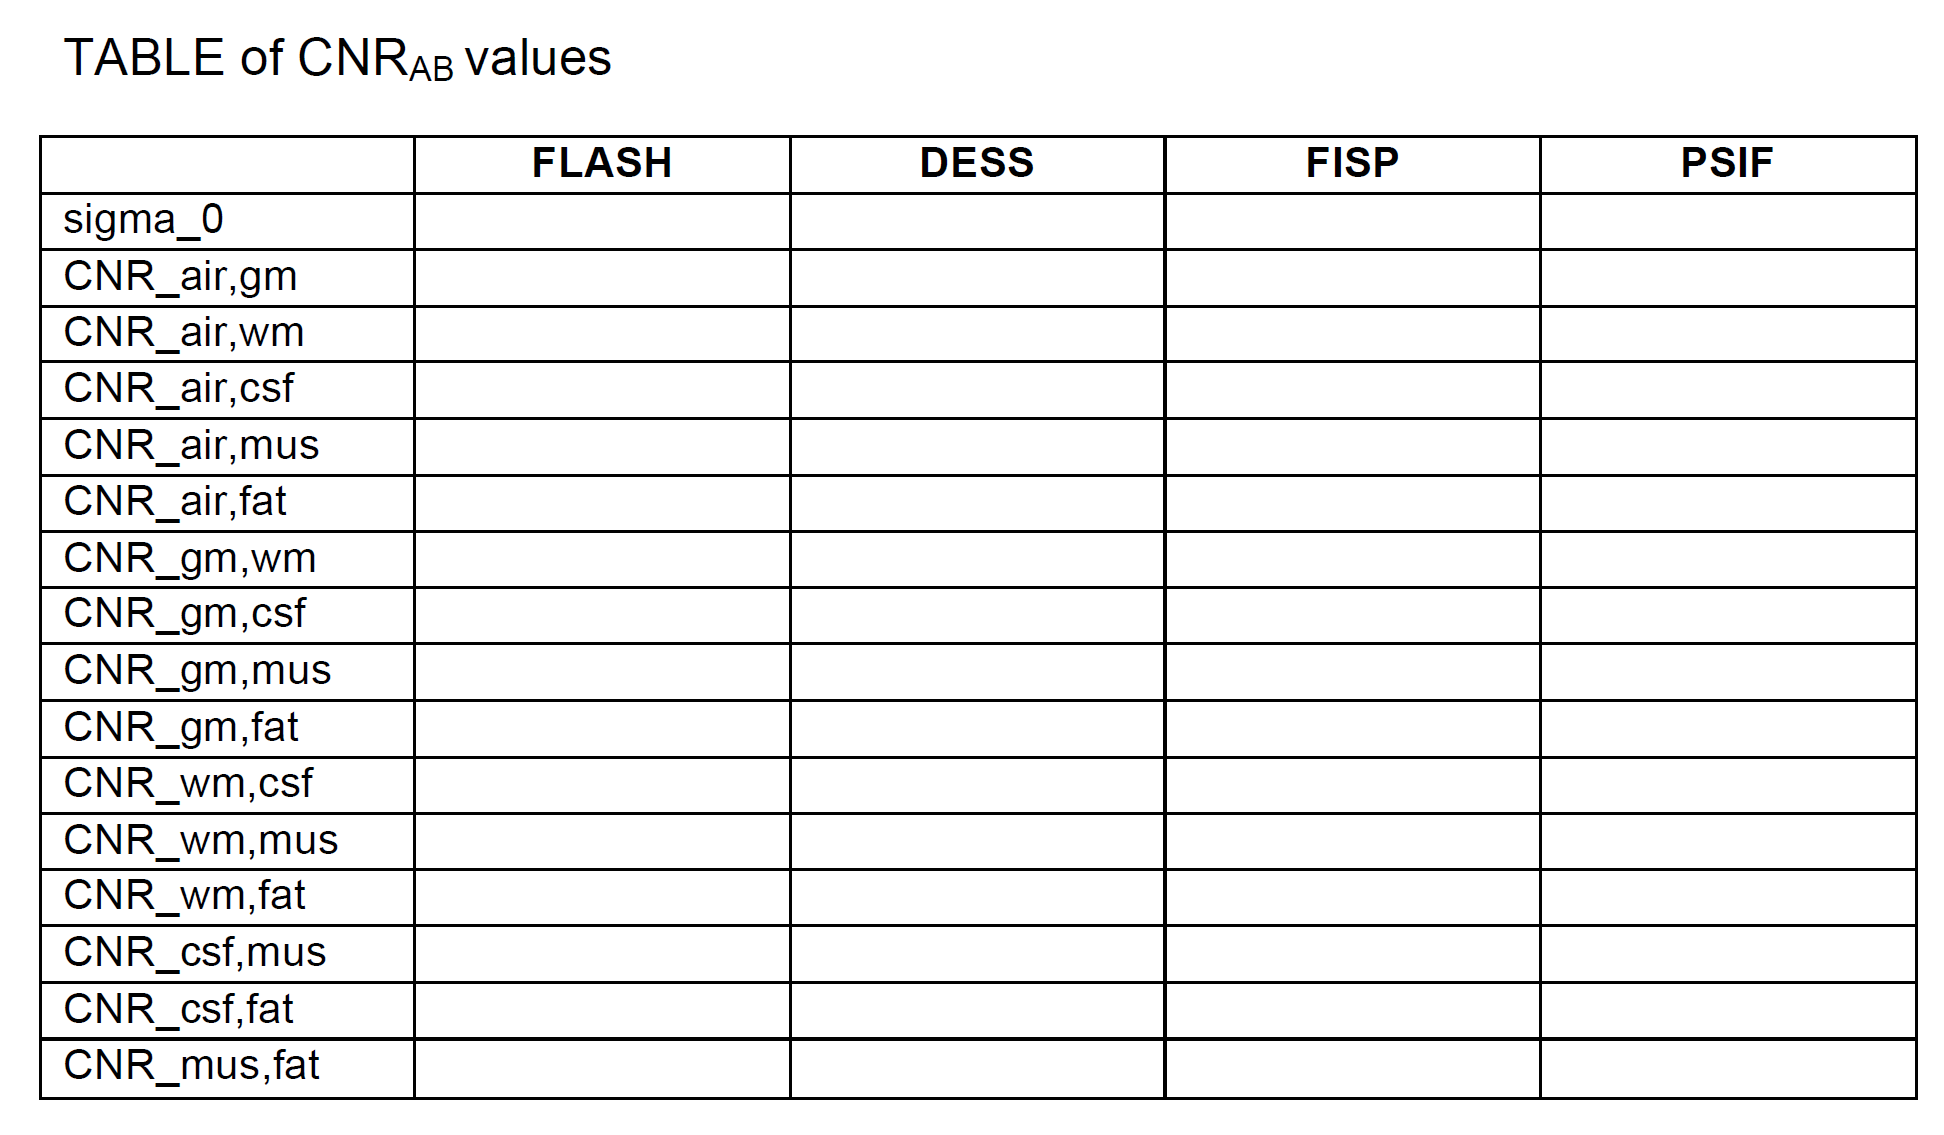

In [71]:
from IPython.display import Image
Image(filename='./assets/multispectral_mri_cnr_table.png', width=600)

- For which pair of tissue classes and in which channel do we find the largest contrast-to-noise ratio?

- Which channel expresses the smallest noise level (as we have previously defined `image noise`)?

_(The brain mask (ROI mask) has not been actively used in this session, and we will come back to it's use in the next part dealing with **tissue classification** using machine learning methods)_